In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
num_per_class = 1000
image_size = 91

x = np.linspace(-4, 4, image_size)
x, y = np.meshgrid(x, x)

widths = [1.8, 2.4]

images = torch.zeros(2*num_per_class, 1, image_size, image_size)
labels = torch.zeros(2*num_per_class)

for i in range(2*num_per_class):
    random_offset = 2*np.random.randn(2)
    gaussian = np.exp(-((x - random_offset[0])**2 + (y - random_offset[1])**2)/(2*widths[i%2]**2))
    
    gaussian = gaussian + np.random.randn(image_size, image_size)/5
    
    images[i, :, :, :] = torch.Tensor(gaussian).view(1, image_size, image_size)
    labels[i] = i%2

labels = labels[:, None]

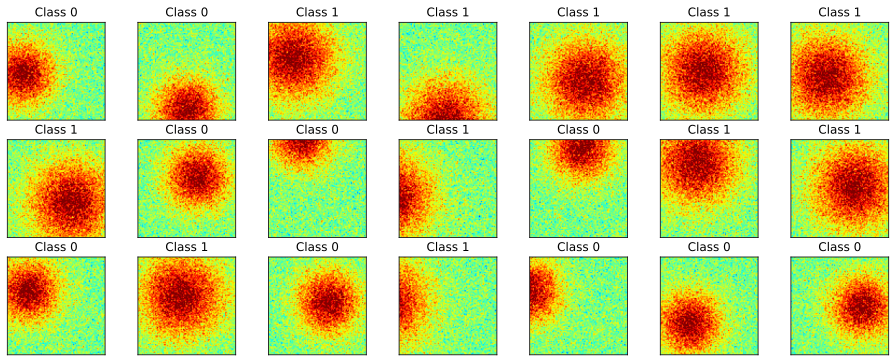

In [3]:
_, axis = plt.subplots(3, 7, figsize=(16, 6))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(2*num_per_class)
    gaussian = np.squeeze(images[pic, :, :])
    ax.imshow(gaussian, vmin=-1, vmax=1, cmap="jet")
    ax.set_title("Class %s"%int(labels[pic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=17)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1), 
                nn.ReLU(), 
                nn.AvgPool2d(2, 2), 
                nn.Conv2d(6, 4, 3, padding=1), 
                nn.ReLU(), 
                nn.AvgPool2d(2, 2), 
                nn.Flatten(), 
                nn.Linear(22*22*4, 50), 
                nn.Linear(50, 1)
            )
        
        def forward(self, x):
            return self.enc(x)
    
    cnn = CNN()
    
    loss_fun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    
    return cnn, loss_fun, optimizer

In [6]:
summary(model()[0].to(device="cuda:0"), (1, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [7]:
def train_model():
    num_epochs = 10

    cnn, loss_fun, optimizer = model()
        
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            y_hat = cnn(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_acc.append(torch.mean(((y_hat > 0.5) == y).float()).item())
        
        train_loss.append(np.mean(batch_loss))
        train_acc.append(100*np.mean(batch_acc))
        
        x, y = next(iter(test_loader))
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
        
        test_loss.append(loss.item())
        test_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
        
    return test_acc, train_acc, test_loss, train_loss, cnn

In [8]:
test_acc, train_acc, test_loss, train_loss, cnn = train_model()

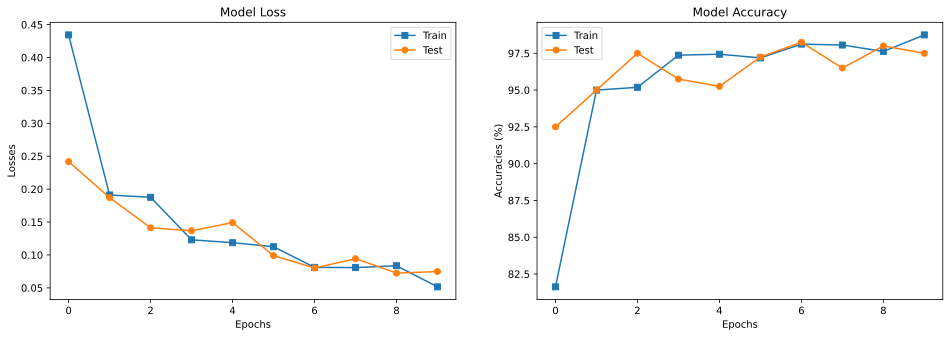

In [9]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_loss, 's-', label="Train")
axis[0].plot(test_loss, 'o-', label="Test")
axis[0].set_ylabel("Losses")
axis[0].set_xlabel("Epochs")
axis[0].set_title("Model Loss")
axis[0].legend()

axis[1].plot(train_acc, 's-', label="Train")
axis[1].plot(test_acc, 'o-', label="Test")
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_xlabel("Epochs")
axis[1].set_title("Model Accuracy")
axis[1].legend();

In [10]:
print(cnn)

CNN(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)



torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


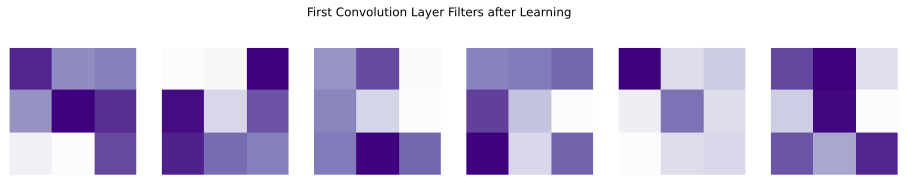

In [11]:
layer_1_weights = cnn.enc[0].weight
layer_3_weights = cnn.enc[3].weight

print("")
print(layer_1_weights.shape)
print(layer_3_weights.shape)

_, axis = plt.subplots(1, 6, figsize=(16, 3))

for i, ax in enumerate(axis.flatten()):
    ax.imshow(torch.squeeze(layer_1_weights[i, :, :, :]).detach(), cmap="Purples")
    ax.axis("off")

plt.suptitle("First Convolution Layer Filters after Learning");

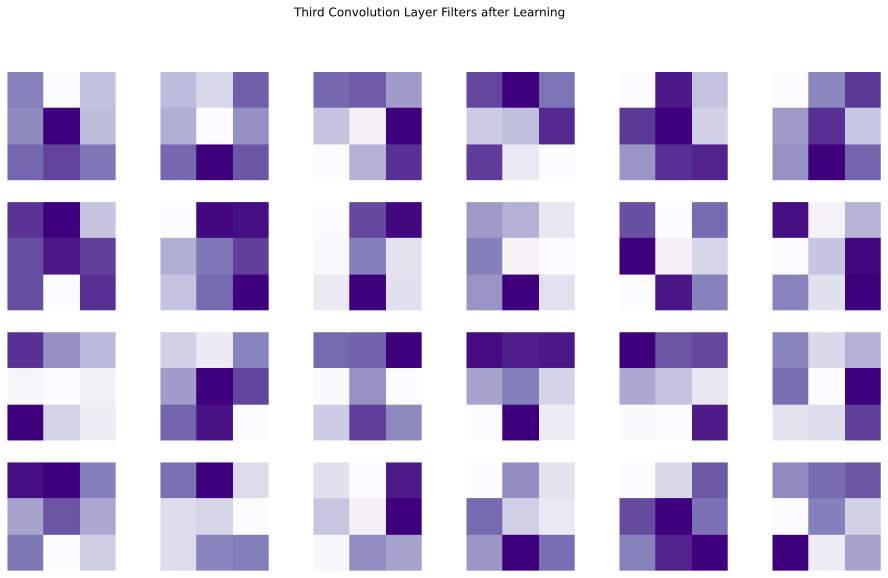

In [12]:
_, axis = plt.subplots(4, 6, figsize=(16, 9))

for i in range(24):
    index = np.unravel_index(i, (4, 6))
    axis[index].imshow(torch.squeeze(layer_3_weights[index[0], index[1], :, :]).detach(), cmap="Purples")
    axis[index].axis("off")

plt.suptitle("Third Convolution Layer Filters after Learning");